<h1> Autoencoder </h1>
Autoencoders are a fairly straightforward network structure, characterised by a "bottleneck" where the input is "compressed" before being upsampled again. This network can be used to create compressed representations of images by training the model to reconstruct the input on the output. It could also be used for our segmentation problem! However in segmentation, we don't really want our network to compress our image, we want it to do some "work" and then give us a segmented version of the input!
<img src="https://miro.medium.com/max/3148/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" width="750" align="center">

[Autoencoders](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

In [2]:
batch_size = 64

# Define learning rate
lr = 1e-4

# Number of Training epochs
nepoch = 10

# Dataset location
root = "../../datasets"

# Scale for the added image noise
noise_scale = 0.3

In [3]:
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

<h3>Create an MNIST dataset and dataloader</h3>

In [4]:
# Define our transform
# We'll upsample the images to 32x32 as it's easier to contruct our network
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])])

train_set = Datasets.MNIST(root=root, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=root, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

100%|██████████| 9.91M/9.91M [00:14<00:00, 668kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 71.2kB/s]
100%|██████████| 1.65M/1.65M [00:07<00:00, 232kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.6MB/s]


<h3>Transpose Convolution</h3>
The AE model introduces a new layer-type the <a href="https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html">Transpose convolution</a> (sometimes called "Deconvolution")<br>
The transpose convolution is a "learnable upsampling" method and is essentially the opposite of a convolution! We take a single feature (pixel) in our feature map and replicate it and multiply by a kernel, any overlapping sections are added together. The easiest way to understand them is with the following animation (where the blue square is the input and green is the output).
<img src="https://miro.medium.com/max/986/1*yoQ62ckovnGYV2vSIq9q4g.gif" width="750" align="center">

[Blog: Transposed Convolutions explained](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8)<br>
[Blog: Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)

## AE Network

In [5]:
# # We split up our network into two parts, the Encoder and the Decoder
# class DownBlock(nn.Module):
#     def __init__(self, channels_in, channels_out):
#         super(DownBlock, self).__init__()
#         self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
#         self.bn1 = nn.BatchNorm2d(channels_out)
        
#         self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)
#         self.bn2 = nn.BatchNorm2d(channels_out)
        
#         self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

#     def forward(self, x):
#         x_skip = self.conv3(x)
        
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.conv2(x) + x_skip
        
#         return F.relu(self.bn2(x))
    
# # We split up our network into two parts, the Encoder and the Decoder
# class UpBlock(nn.Module):
#     def __init__(self, channels_in, channels_out):
#         super(UpBlock, self).__init__()
#         self.bn1 = nn.BatchNorm2d(channels_in)

#         self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
#         self.bn2 = nn.BatchNorm2d(channels_in)

#         self.conv2 = nn.ConvTranspose2d(channels_in, channels_out, 3, 2, 1, 1)
        
#         self.conv3 = nn.ConvTranspose2d(channels_in, channels_out, 3, 2, 1, 1)

#     def forward(self, x_in):
#         x = F.relu(self.bn2(x_in))
        
#         x_skip = self.conv3(x)
        
#         x = F.relu(self.bn2(self.conv1(x)))
#         return self.conv2(x) + x_skip

In [6]:
# # We split up our network into two parts, the Encoder and the Decoder
# class Encoder(nn.Module):
#     def __init__(self, channels, ch=32, z=32):
#         super(Encoder, self).__init__()
#         self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

#         self.conv_block1 = DownBlock(ch, ch)
#         self.conv_block2 = DownBlock(ch, ch * 2)
#         self.conv_block3 = DownBlock(ch * 2, ch * 4)

#         self.conv_out = nn.Conv2d(4 * ch, z, 4, 1)
        
#     def forward(self, x):
#         x = F.relu(self.conv_1(x))
        
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         x = self.conv_block3(x)

#         return self.conv_out(x)
    
# class Decoder(nn.Module):
#     def __init__(self, channels, ch = 32, z = 32):
#         super(Decoder, self).__init__()
        
#         self.conv1 = nn.ConvTranspose2d(z, 4 * ch, 4, 1)
        
#         self.conv_block1 = UpBlock(4 * ch, 2 * ch)
#         self.conv_block2 = UpBlock(2 * ch, ch)
#         self.conv_block3 = UpBlock(ch, ch)
#         self.bn1 = nn.BatchNorm2d(ch)

#         self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

#     def forward(self, x):
#         x = self.conv1(x)
        
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         x = F.relu(self.bn1(self.conv_block3(x)))

#         return torch.tanh(self.conv_out(x))

In [7]:
# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, z=32):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, ch, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, 2 * ch, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(2 * ch)
        self.conv3 = nn.Conv2d(2 * ch, 4 * ch, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(4 * ch)

        self.conv_out = nn.Conv2d(4 * ch, z, 4, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        return self.conv_out(x)
    
class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, z = 32):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(z, 4 * ch, 4, 1)
        self.bn1 = nn.BatchNorm2d(4 * ch)
        self.conv2 = nn.ConvTranspose2d(4 * ch, 2 * ch, 3, 2, 1, 1)
        self.bn2 = nn.BatchNorm2d(2 * ch)
        self.conv3 = nn.ConvTranspose2d(2 * ch, ch, 3, 2, 1, 1)
        self.bn3 = nn.BatchNorm2d(ch)
        self.conv4 = nn.ConvTranspose2d(ch, ch, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(ch)

        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        return torch.tanh(self.conv_out(x))
    
class AE(nn.Module):
    def __init__(self, channel_in, ch=16, z=32):
        super(AE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, z=z)
        self.decoder = Decoder(channels=channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding = self.encoder(x)
        x = self.decoder(encoding)
        return x, encoding

<h3>Visualize our data</h3>

In [10]:
# Get a test image
dataiter = iter(test_loader)
test_images = next(dataiter)[0]
# View the shape
test_images.shape

torch.Size([64, 1, 32, 32])

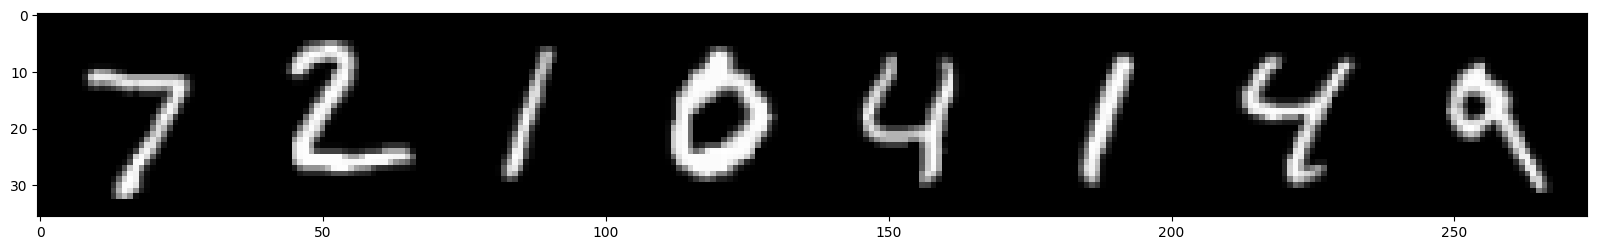

In [11]:
# Visualize the data!!!
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### De-noising Autoencoder
While an Autoencoder can be used to simply compress the input into a lower-dimentional space lets also see how we can use it to remove some noise from an image!<br>
We're going to simulate some [salt-and-pepper noise!](https://en.wikipedia.org/wiki/Salt-and-pepper_noise)

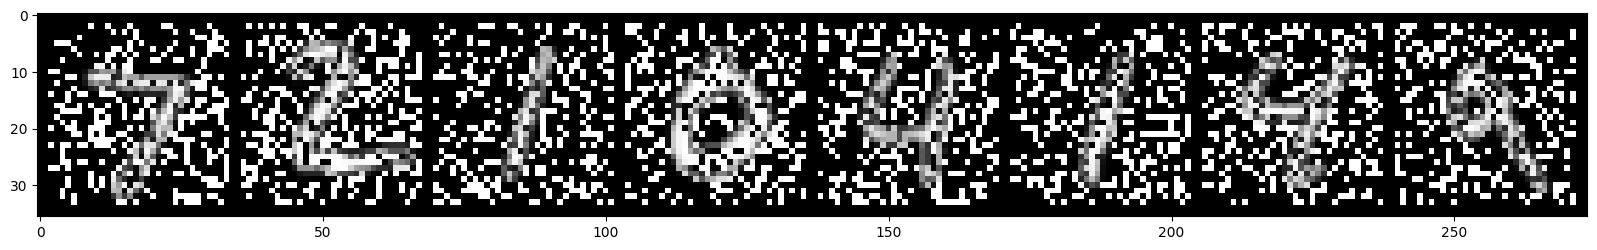

In [12]:
# Visualize the data!!!
plt.figure(figsize = (20, 10))
random_sample = (torch.bernoulli((1 - noise_scale) * torch.ones_like(test_images)) * 2) - 1
noisy_test_img = random_sample * test_images

out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

<h3>Create Network and Optimizer</h3>

In [13]:
# The size of the Latent Vector
latent_size = 128

# Create our network
ae_net = AE(channel_in=1, z=latent_size).to(device)

# Setup optimizer
optimizer = optim.Adam(ae_net.parameters(), lr=lr)

# MSE loss for reconstruction!
loss_func = nn.MSELoss()

loss_log = []
train_loss = 0

<h4>Network output</h4>

In [14]:
# Pass through a test image to make sure everything is working
recon_data, encoding = ae_net(test_images.to(device))

# View the Latent vector shape
encoding.shape

torch.Size([64, 128, 1, 1])

<h2>Start training!</h2>

In [15]:
pbar = trange(0, nepoch, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data[0].to(device)
        
        random_sample = (torch.bernoulli((1 - noise_scale) * torch.ones_like(image)) * 2) - 1
        noisy_img = random_sample * image
        
        # Forward pass the image in the data tuple
        recon_data, _ = ae_net(noisy_img)
        
        # Calculate the MSE loss
        loss = loss_func(recon_data, image)
        
        # Log the loss
        loss_log.append(loss.item())
        train_loss += loss.item()
        
        # Take a training step
        ae_net.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

## Results!

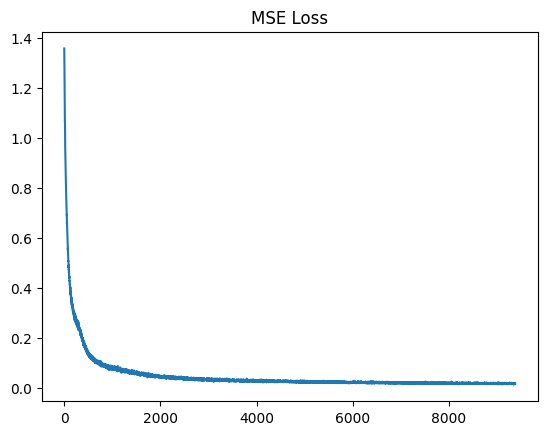

In [16]:
_ = plt.plot(loss_log)
_ = plt.title("MSE Loss")

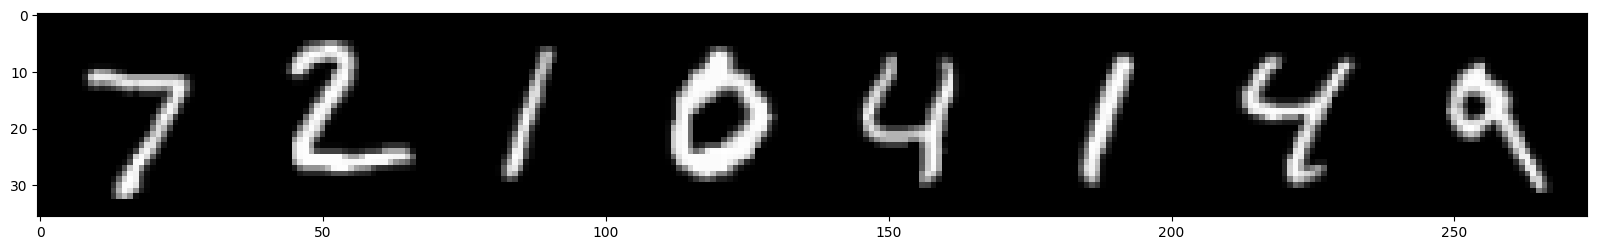

In [17]:
# Ground Truth
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

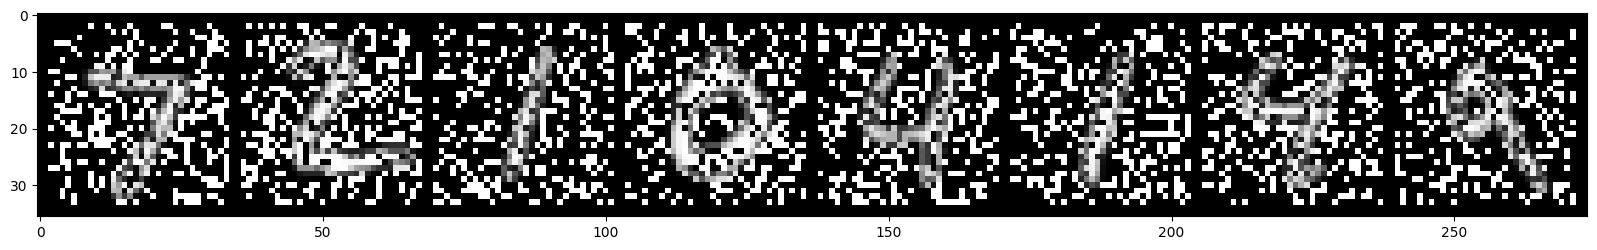

In [18]:
# Noisy Input
plt.figure(figsize = (20,10))
out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

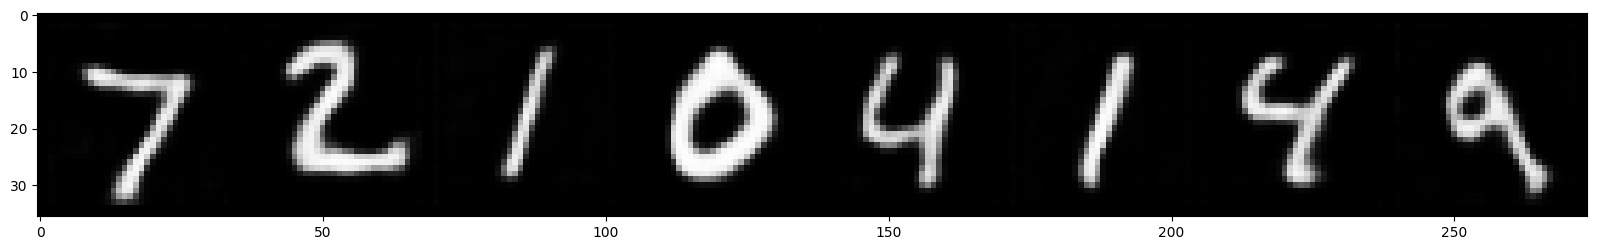

In [19]:
# Reconstruction
plt.figure(figsize = (20,10))
recon_data, encoding = ae_net(noisy_test_img.to(device))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

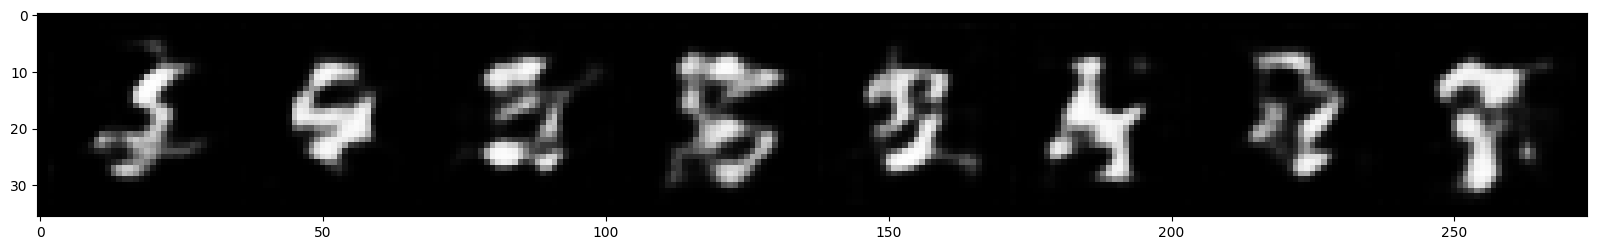

In [20]:
# Reconstruction
plt.figure(figsize = (20,10))
recon_data = ae_net.decoder(encoding.std(0, keepdims=True) * torch.randn_like(encoding) + encoding.mean(0, keepdims=True))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))